# 3.1 Task 1: Calculating the Win Rate

In [1]:
import time
import warnings
import pandas as pd 
import numpy as np 
import scipy.special
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.exceptions import ConvergenceWarning
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score,f1_score,plot_confusion_matrix,classification_report,mean_squared_error,r2_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.utils.fixes import loguniform



In [2]:
#Read csv files and store as dataframe
dfPokemon = pd.read_csv("./pokemon.csv")
dfBattles = pd.read_csv("./battles.csv")


In [3]:
#Check for null values in Pokemon data
dfPokemon.isnull().sum()

#               0
Name            1
Type 1          0
Type 2        386
HP              0
Attack          0
Defense         0
Sp. Atk         0
Sp. Def         0
Speed           0
Generation      0
Has Gender      0
Legendary       0
dtype: int64

In [4]:
#Check for null values in Combat data
dfBattles.isnull().sum()

First_pokemon     0
Second_pokemon    0
Winner            0
dtype: int64

In [5]:
display(dfPokemon[dfPokemon['Name'].isnull()])

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Has Gender,Legendary
62,63,NaN,Fighting,NaN,65,105,60,60,70,95,1,True,False


In [6]:
#Pokemon missing is Primeape, updated from the official Pokemon list
#https://en.wikipedia.org/wiki/List_of_Pok%C3%A9mon
dfPokemon.loc[62, 'Name'] = "Primeape"

In [7]:
#Count fights by first, second pokemon and count wins by pokemon
countFirst = dfBattles.groupby('First_pokemon').count()
countSecond = dfBattles.groupby('Second_pokemon').count()
countWins = dfBattles.groupby('Winner').count()


#Aggregate counts by first and second, then calculate win rate by Wins/Total Fights
countTotalFights = countFirst + countSecond
countTotalFights["Total Fights"] = countFirst.Second_pokemon + countSecond.First_pokemon
countTotalFights["Wins"] = countWins["First_pokemon"]
countTotalFights["Win Rate"] = countTotalFights["Wins"]/countTotalFights["Total Fights"]


#Change column names of dataframe to Total Fights and Win Rate, also rename index co
countTotalFights.drop(columns={"First_pokemon", "Second_pokemon", "Winner"},inplace=True)
countTotalFights.index.name = "#"
display(countTotalFights)



,Total Fights,Wins,Win Rate
#,,,
1,102,26.0,0.254902
2,96,38.0,0.395833
3,103,65.0,0.631068
4,95,55.0,0.578947
5,92,41.0,0.445652
...,...,...,...
796,88,34.0,0.386364
797,102,93.0,0.911765
798,89,47.0,0.528090


In [8]:
#Check for missing/incorrect values for Win Rate
display(countTotalFights[countTotalFights['Win Rate'].isnull()]) #Check null
display(countTotalFights[countTotalFights['Win Rate']>1]) #Check win rates greater than 1

#Fill missing values with 0 i.e. Fill missing values for the Pokemon that fought but not won
countTotalFights.loc[231, ["Total Fights", "Win Rate", "Wins"]] = 0

,Total Fights,Wins,Win Rate
#,,,
231,107,NaN,NaN


,Total Fights,Wins,Win Rate
#,,,


In [9]:
#Merge Win Rate dataframe with main Pokemon dataframe
dfPokemon = pd.merge(dfPokemon, countTotalFights, left_on='#', right_index = True, how='left')
dfPokemon.drop(columns={"Total Fights", "Wins"},inplace=True,axis=1)
display(dfPokemon)

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Has Gender,Legendary,Win Rate
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,True,False,0.254902
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,True,False,0.395833
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,True,False,0.631068
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,True,False,0.578947
4,5,Charmander,Fire,NaN,39,52,43,60,50,65,1,True,False,0.445652
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,796,Diancie,Rock,Fairy,50,100,150,100,150,50,6,False,True,0.386364
796,797,Mega Diancie,Rock,Fairy,50,160,110,160,110,110,6,False,True,0.911765
797,798,Hoopa Confined,Psychic,Ghost,80,110,60,150,130,70,6,False,True,0.528090
798,799,Hoopa Unbound,Psychic,Dark,80,160,60,170,130,80,6,False,True,0.617886


In [10]:
#Fill Type 2 NA entries with "None"
dfPokemon["Type 2"].fillna(value="None",inplace=True)
display(dfPokemon)

#Search for Pokemon that had not participated in battles or have incorrect win rates
display(dfPokemon[(dfPokemon['Win Rate'].isnull()) | (dfPokemon['Win Rate']>1)])

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Has Gender,Legendary,Win Rate
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,True,False,0.254902
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,True,False,0.395833
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,True,False,0.631068
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,True,False,0.578947
4,5,Charmander,Fire,None,39,52,43,60,50,65,1,True,False,0.445652
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,796,Diancie,Rock,Fairy,50,100,150,100,150,50,6,False,True,0.386364
796,797,Mega Diancie,Rock,Fairy,50,160,110,160,110,110,6,False,True,0.911765
797,798,Hoopa Confined,Psychic,Ghost,80,110,60,150,130,70,6,False,True,0.528090
798,799,Hoopa Unbound,Psychic,Dark,80,160,60,170,130,80,6,False,True,0.617886


,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Has Gender,Legendary,Win Rate
11,12,Blastoise,Water,None,79,83,100,85,105,78,1,True,False,NaN
32,33,Sandshrew,Ground,None,50,75,85,20,30,40,1,True,False,NaN
45,46,Wigglytuff,Normal,Fairy,140,70,45,85,50,45,1,True,False,NaN
65,66,Poliwag,Water,None,40,50,40,40,40,90,1,True,False,NaN
77,78,Victreebel,Grass,Poison,80,105,65,100,70,70,1,True,False,NaN
89,90,Magneton,Electric,Steel,50,60,95,120,70,70,1,False,False,NaN
143,144,Ditto,Normal,None,48,48,48,48,48,48,1,False,False,NaN
182,183,Ariados,Bug,Poison,70,90,70,60,60,40,2,True,False,NaN
235,236,Ursaring,Normal,None,90,130,75,75,75,55,2,True,False,NaN
321,322,Hariyama,Fighting,None,144,120,60,40,60,50,3,True,False,NaN


In [11]:
#[Q1]Define Total Stats as the sum of HP, Attack, Defense, Sp. Atk, Sp. Def, Speed and define the feature in the column "Total Stats"
dfPokemon["Total Stats"] = dfPokemon["HP"] +dfPokemon["Attack"] + dfPokemon["Defense"] + dfPokemon["Sp. Atk"] + dfPokemon["Sp. Def"] + dfPokemon["Speed"]
display(dfPokemon)

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Has Gender,Legendary,Win Rate,Total Stats
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,True,False,0.254902,318
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,True,False,0.395833,405
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,True,False,0.631068,525
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,True,False,0.578947,625
4,5,Charmander,Fire,None,39,52,43,60,50,65,1,True,False,0.445652,309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,796,Diancie,Rock,Fairy,50,100,150,100,150,50,6,False,True,0.386364,600
796,797,Mega Diancie,Rock,Fairy,50,160,110,160,110,110,6,False,True,0.911765,700
797,798,Hoopa Confined,Psychic,Ghost,80,110,60,150,130,70,6,False,True,0.528090,600
798,799,Hoopa Unbound,Psychic,Dark,80,160,60,170,130,80,6,False,True,0.617886,680


In [12]:
#[Q1]Select pokemons with Fights AND Win rate to use a training data for linear regression interpolation
dfPokemonNoFight = dfPokemon.loc[(dfPokemon["Win Rate"].isnull())|(dfPokemon["Win Rate"]>1)]
display(dfPokemonNoFight)

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Has Gender,Legendary,Win Rate,Total Stats
11,12,Blastoise,Water,None,79,83,100,85,105,78,1,True,False,NaN,530
32,33,Sandshrew,Ground,None,50,75,85,20,30,40,1,True,False,NaN,300
45,46,Wigglytuff,Normal,Fairy,140,70,45,85,50,45,1,True,False,NaN,435
65,66,Poliwag,Water,None,40,50,40,40,40,90,1,True,False,NaN,300
77,78,Victreebel,Grass,Poison,80,105,65,100,70,70,1,True,False,NaN,490
89,90,Magneton,Electric,Steel,50,60,95,120,70,70,1,False,False,NaN,465
143,144,Ditto,Normal,None,48,48,48,48,48,48,1,False,False,NaN,288
182,183,Ariados,Bug,Poison,70,90,70,60,60,40,2,True,False,NaN,390
235,236,Ursaring,Normal,None,90,130,75,75,75,55,2,True,False,NaN,500
321,322,Hariyama,Fighting,None,144,120,60,40,60,50,3,True,False,NaN,474


In [13]:
#[Q1]Select pokemons with no fights to predict their win rates with interpolation
dfPokemonYesFight = dfPokemon.loc[(dfPokemon["Win Rate"].isnull()==False)&(dfPokemon["Win Rate"]<1)]
display(dfPokemonYesFight)

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Has Gender,Legendary,Win Rate,Total Stats
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,True,False,0.254902,318
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,True,False,0.395833,405
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,True,False,0.631068,525
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,True,False,0.578947,625
4,5,Charmander,Fire,None,39,52,43,60,50,65,1,True,False,0.445652,309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,796,Diancie,Rock,Fairy,50,100,150,100,150,50,6,False,True,0.386364,600
796,797,Mega Diancie,Rock,Fairy,50,160,110,160,110,110,6,False,True,0.911765,700
797,798,Hoopa Confined,Psychic,Ghost,80,110,60,150,130,70,6,False,True,0.528090,600
798,799,Hoopa Unbound,Psychic,Dark,80,160,60,170,130,80,6,False,True,0.617886,680


In [14]:
#[Q1]Train/fit the linear regression model with the features of Pokemons that fought as inputs, and their respective
#Win rates as outputs 
linreg = LinearRegression()
linreg.fit(dfPokemonYesFight["Total Stats"].values.reshape(-1,1),dfPokemonYesFight["Win Rate"].values.reshape(-1,1))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [15]:
#[Q1]Predict the Win Rates with the Pokemons that did not fight with their features as input
dfPokemonNoFight['Win Rate'] = linreg.predict(dfPokemonNoFight["Total Stats"].values.reshape(-1,1))
display(dfPokemonNoFight)

C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Has Gender,Legendary,Win Rate,Total Stats
11,12,Blastoise,Water,None,79,83,100,85,105,78,1,True,False,0.631267,530
32,33,Sandshrew,Ground,None,50,75,85,20,30,40,1,True,False,0.314843,300
45,46,Wigglytuff,Normal,Fairy,140,70,45,85,50,45,1,True,False,0.500570,435
65,66,Poliwag,Water,None,40,50,40,40,40,90,1,True,False,0.314843,300
77,78,Victreebel,Grass,Poison,80,105,65,100,70,70,1,True,False,0.576236,490
89,90,Magneton,Electric,Steel,50,60,95,120,70,70,1,False,False,0.541843,465
143,144,Ditto,Normal,None,48,48,48,48,48,48,1,False,False,0.298334,288
182,183,Ariados,Bug,Poison,70,90,70,60,60,40,2,True,False,0.438661,390
235,236,Ursaring,Normal,None,90,130,75,75,75,55,2,True,False,0.589994,500
321,322,Hariyama,Fighting,None,144,120,60,40,60,50,3,True,False,0.554224,474


In [16]:
#[Q1]Merge the predictions into the main Pokemon dataframe i.e. dfPokemon 
dfPokemon.loc[(dfPokemon["Win Rate"].isnull())|(dfPokemon["Win Rate"]>1)] = dfPokemonNoFight
display(dfPokemon.loc[(dfPokemon["Win Rate"].isnull())|(dfPokemon["Win Rate"]>1)])
dfPokemon.drop(columns = "Total Stats", axis=1, inplace=True)
display(dfPokemon)

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Has Gender,Legendary,Win Rate,Total Stats


,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Has Gender,Legendary,Win Rate
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,True,False,0.254902
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,True,False,0.395833
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,True,False,0.631068
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,True,False,0.578947
4,5,Charmander,Fire,None,39,52,43,60,50,65,1,True,False,0.445652
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,796,Diancie,Rock,Fairy,50,100,150,100,150,50,6,False,True,0.386364
796,797,Mega Diancie,Rock,Fairy,50,160,110,160,110,110,6,False,True,0.911765
797,798,Hoopa Confined,Psychic,Ghost,80,110,60,150,130,70,6,False,True,0.528090
798,799,Hoopa Unbound,Psychic,Dark,80,160,60,170,130,80,6,False,True,0.617886


# 3.2 Task 2: Finding the Most Correlated Feature using Linear Regression

R-square: 0.12


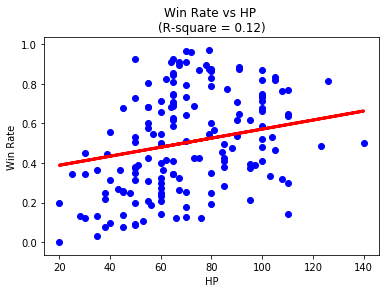

In [17]:
#[Q2, Q3]Train->predict->plot model results with linear regression model for HP
X_HP = dfPokemon[['HP']]
y_HP = dfPokemon['Win Rate']
X_HP_train, X_HP_valid, y_HP_train, y_HP_valid = train_test_split(X_HP, y_HP, test_size=0.2, random_state=4211)
lmHP = LinearRegression()
lmHP.fit(X_HP_train, y_HP_train)
y_HP_pred = lmHP.predict(X_HP_valid)
print('R-square: %.2f' % r2_score(y_HP_valid, y_HP_pred))

# Plot outputs
plt.scatter(X_HP_valid, y_HP_valid,  color='blue')
plt.plot(X_HP_valid, y_HP_pred, color='red', linewidth=3)
plt.xticks(())
plt.yticks(())
plt.xlabel('HP')
plt.ylabel('Win Rate')
plt.xticks([20,40,60,80,100,120,140])
plt.yticks([1,0.8,0.6,0.4,0.2,0.0])
plt.title("Win Rate vs HP \n(R-square = 0.12)")
plt.show()

R-square: 0.23


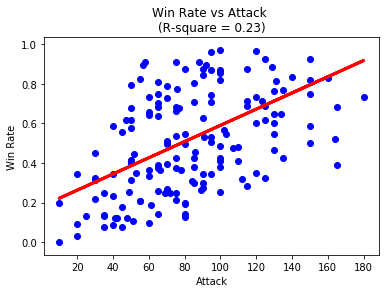

In [18]:
#[Q2, Q3]Train->predict->plot model results with linear regression model for Attach
X_Attack = dfPokemon[['Attack']]
y_Attack = dfPokemon['Win Rate']
X_Attack_train, X_Attack_valid, y_Attack_train, y_Attack_valid = train_test_split(X_Attack, y_Attack, test_size=0.2, random_state=4211)
lmAttack = LinearRegression()
lmAttack.fit(X_Attack_train, y_Attack_train)
y_Attack_pred = lmAttack.predict(X_Attack_valid)
print('R-square: %.2f' % r2_score(y_Attack_valid, y_Attack_pred))

# Plot outputs
plt.scatter(X_Attack_valid, y_Attack_valid,  color='blue')
plt.plot(X_Attack_valid, y_Attack_pred, color='red', linewidth=3)
plt.xlabel('Attack')
plt.ylabel('Win Rate')
plt.xticks([20,40,60,80,100,120,140,160,180])
plt.yticks([1,0.8,0.6,0.4,0.2,0.0])
plt.title("Win Rate vs Attack \n(R-square = 0.23)")
plt.show()

R-square: -0.01


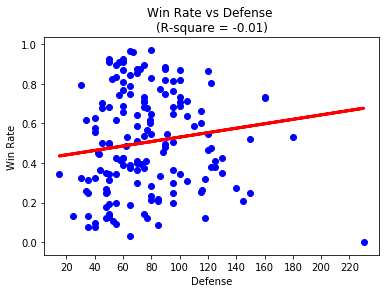

In [19]:
#[Q2, Q3]Train->predict->plot model results with linear regression model for Defense
X_Defense = dfPokemon[['Defense']]
y_Defense = dfPokemon['Win Rate']
X_Defense_train, X_Defense_valid, y_Defense_train, y_Defense_valid = train_test_split(X_Defense, y_Defense, test_size=0.2, random_state=4211)
lmDefense = LinearRegression()
lmDefense.fit(X_Defense_train, y_Defense_train)
y_Defense_pred = lmDefense.predict(X_Defense_valid)
print('R-square: %.2f' % r2_score(y_Defense_valid, y_Defense_pred))

# Plot outputs
plt.scatter(X_Defense_valid, y_Defense_valid,  color='blue')
plt.plot(X_Defense_valid, y_Defense_pred, color='red', linewidth=3)
plt.xlabel('Defense')
plt.ylabel('Win Rate')
plt.xticks([20,40,60,80,100,120,140,160,180,200,220])
plt.yticks([1,0.8,0.6,0.4,0.2,0.0])
plt.title("Win Rate vs Defense \n(R-square = -0.01)")
plt.show()

R-square: 0.25


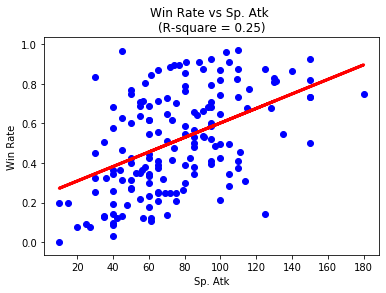

In [20]:
#[Q2, Q3]Train->predict->plot model results with linear regression model for Sp. Atk
X_SpAtk = dfPokemon[['Sp. Atk']]
y_SpAtk = dfPokemon['Win Rate']
X_SpAtk_train, X_SpAtk_valid, y_SpAtk_train, y_SpAtk_valid = train_test_split(X_SpAtk, y_SpAtk, test_size=0.2, random_state=4211)
lmSpAtk = LinearRegression()
lmSpAtk.fit(X_SpAtk_train, y_SpAtk_train)
y_SpAtk_pred = lmSpAtk.predict(X_SpAtk_valid)
print('R-square: %.2f' % r2_score(y_SpAtk_valid, y_SpAtk_pred))

plt.scatter(X_SpAtk_valid, y_SpAtk_valid,  color='blue')
plt.plot(X_SpAtk_valid, y_SpAtk_pred, color='red', linewidth=3)
plt.ylabel('Win Rate')
plt.xlabel('Sp. Atk')
plt.yticks([1,0.8,0.6,0.4,0.2,0.0])
plt.xticks([20,40,60,80,100,120,140,160,180])
plt.title("Win Rate vs Sp. Atk \n(R-square = 0.25)")
plt.show()

R-square: 0.01


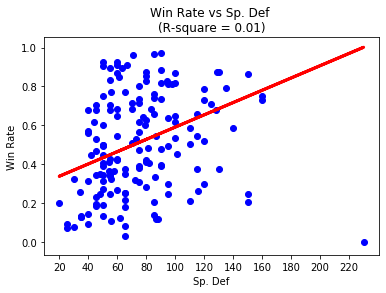

In [21]:
#[Q2, Q3]Train->predict->plot model results with linear regression model for Sp. Def
X_SpDef = dfPokemon[['Sp. Def']]
y_SpDef = dfPokemon['Win Rate']
X_SpDef_train, X_SpDef_valid, y_SpDef_train, y_SpDef_valid = train_test_split(X_SpDef, y_SpDef, test_size=0.2, random_state=4211)
lmSpDef = LinearRegression()
lmSpDef.fit(X_SpDef_train, y_SpDef_train)
y_SpDef_pred = lmSpDef.predict(X_SpDef_valid)
print('R-square: %.2f' % r2_score(y_SpDef_valid, y_SpDef_pred))

#Plot output
plt.scatter(X_SpDef_valid, y_SpDef_valid,  color='blue')
plt.plot(X_SpDef_valid, y_SpDef_pred, color='red', linewidth=3)
plt.ylabel('Win Rate')
plt.xlabel('Sp. Def')
plt.yticks([1,0.8,0.6,0.4,0.2,0.0])
plt.xticks([20,40,60,80,100,120,140,160,180,200,220])
plt.title("Win Rate vs Sp. Def \n(R-square = 0.01)")
plt.show()

Variance score: 0.88


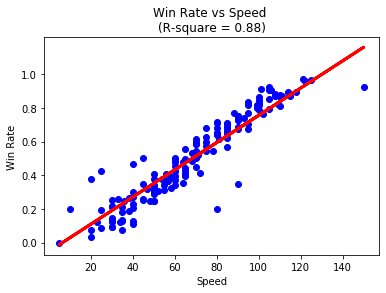

In [22]:
#[Q2, Q3]Train->predict->plot model results with linear regression model for Speed
X_Speed = dfPokemon[['Speed']]
y_Speed = dfPokemon['Win Rate']
X_Speed_train, X_Speed_valid, y_Speed_train, y_Speed_valid = train_test_split(X_Speed, y_Speed, test_size=0.2, random_state=4211)
lmSpeed = LinearRegression()
lmSpeed.fit(X_Speed_train, y_Speed_train)
y_Speed_pred = lmSpeed.predict(X_Speed_valid)
print('Variance score: %.2f' % r2_score(y_Speed_valid, y_Speed_pred))

#Plot output
plt.scatter(X_Speed_valid, y_Speed_valid,  color='blue')
plt.plot(X_Speed_valid, y_Speed_pred, color='red', linewidth=3)
plt.ylabel('Win Rate')
plt.xlabel('Speed')
plt.yticks([1,0.8,0.6,0.4,0.2,0.0])
plt.xticks([20,40,60,80,100,120,140])
plt.title("Win Rate vs Speed \n(R-square = 0.88)")
plt.show()

# Task 3: Legendary Pokemon Classification using Logistic Regression and Single-hidden-layer Neural Networks

# 3.3.1 Logistic Regression

In [23]:
#One hot encoding the categorical variables
Type_1 =  pd.get_dummies(dfPokemon['Type 1'], prefix='Type 1')
dfPokemonOneHotEncoded = pd.concat([dfPokemon, Type_1], axis=1)
                             
Type_2 =  pd.get_dummies(dfPokemon['Type 2'], prefix='Type 2')
dfPokemonOneHotEncoded = pd.concat([dfPokemonOneHotEncoded, Type_2], axis=1)
                             
Has_Gender = pd.get_dummies(dfPokemon['Has Gender'], prefix='Has Gender')
dfPokemonOneHotEncoded = pd.concat([dfPokemonOneHotEncoded, Has_Gender], axis=1)

Legendary = pd.get_dummies(dfPokemon['Legendary'], prefix='Legendary')
dfPokemonOneHotEncoded = pd.concat([dfPokemonOneHotEncoded, Legendary], axis=1)
                             
display(dfPokemonOneHotEncoded)


,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,...,Type 2_Normal,Type 2_Poison,Type 2_Psychic,Type 2_Rock,Type 2_Steel,Type 2_Water,Has Gender_False,Has Gender_True,Legendary_False,Legendary_True
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,...,0,1,0,0,0,0,0,1,1,0
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,...,0,1,0,0,0,0,0,1,1,0
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,...,0,1,0,0,0,0,0,1,1,0
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,...,0,1,0,0,0,0,0,1,1,0
4,5,Charmander,Fire,None,39,52,43,60,50,65,...,0,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,796,Diancie,Rock,Fairy,50,100,150,100,150,50,...,0,0,0,0,0,0,1,0,0,1
796,797,Mega Diancie,Rock,Fairy,50,160,110,160,110,110,...,0,0,0,0,0,0,1,0,0,1
797,798,Hoopa Confined,Psychic,Ghost,80,110,60,150,130,70,...,0,0,0,0,0,0,1,0,0,1
798,799,Hoopa Unbound,Psychic,Dark,80,160,60,170,130,80,...,0,0,0,0,0,0,1,0,0,1


In [24]:
#Selecting X and y datasets for model trainig/validation
X = dfPokemonOneHotEncoded[['Type 1_Bug', 'Type 1_Dark', 'Type 1_Dragon', 'Type 1_Electric',
       'Type 1_Fairy', 'Type 1_Fighting', 'Type 1_Fire', 'Type 1_Flying',
       'Type 1_Ghost', 'Type 1_Grass', 'Type 1_Ground', 'Type 1_Ice',
       'Type 1_Normal', 'Type 1_Poison', 'Type 1_Psychic', 'Type 1_Rock',
       'Type 1_Steel', 'Type 1_Water', 'Type 2_Bug', 'Type 2_Dark',
       'Type 2_Dragon', 'Type 2_Electric', 'Type 2_Fairy', 'Type 2_Fighting',
       'Type 2_Fire', 'Type 2_Flying', 'Type 2_Ghost', 'Type 2_Grass',
       'Type 2_Ground', 'Type 2_Ice', 'Type 2_None', 'Type 2_Normal',
       'Type 2_Poison', 'Type 2_Psychic', 'Type 2_Rock', 'Type 2_Steel',
       'Type 2_Water', 'HP', 'Attack','Defense', 'Sp. Atk','Sp. Def','Speed','Generation','Has Gender_False', 'Has Gender_True']]
y = dfPokemonOneHotEncoded['Legendary_True']

In [25]:
#Train and validation data split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=4211)

In [26]:
#Initialize list of train time, accuracy and f1 score to capture the performance of the models
train_time_logsgd = []
accuracy_logsgd = []
f1_logsgd = []
reportDict = {"Training Time":train_time_logsgd,"Accuracy": accuracy_logsgd,"F1 Score":f1_logsgd}

In [27]:
#Train first model of logistic regression
clf_sgd = SGDClassifier(loss='log', max_iter=100,random_state=1, verbose=1,eta0=0.05,learning_rate='adaptive') # loss='log' means Logistic Regression
t0 = time.time()
clf_sgd.fit(X_train, y_train)
t1 = time.time()
train_time_logsgd.append(t1-t0)
y_pred = clf_sgd.predict(X_valid)

print('clf_sgd_intercept:',clf_sgd.intercept_, 'clf_sgd_coef:', clf_sgd.coef_)
print('accuracy:', accuracy_score(y_valid, y_pred))
accuracy_logsgd.append(accuracy_score(y_valid, y_pred))
print('f1:', f1_score(y_valid, y_pred))
f1_logsgd.append(f1_score(y_valid, y_pred))

-- Epoch 1
Norm: 26.50, NNZs: 45, Bias: -1.175268, T: 640, Avg. loss: 197.790807
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 30.30, NNZs: 46, Bias: -2.176493, T: 1280, Avg. loss: 195.115916
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 33.04, NNZs: 46, Bias: -3.126671, T: 1920, Avg. loss: 195.995710
Total training time: 0.01 seconds.
-- Epoch 4
Norm: 28.46, NNZs: 46, Bias: -4.056564, T: 2560, Avg. loss: 173.858703
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 35.70, NNZs: 46, Bias: -5.107863, T: 3200, Avg. loss: 209.236637
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 35.51, NNZs: 46, Bias: -6.057677, T: 3840, Avg. loss: 190.282737
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 46.59, NNZs: 46, Bias: -7.110234, T: 4480, Avg. loss: 188.101789
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 44.10, NNZs: 46, Bias: -8.044898, T: 5120, Avg. loss: 190.769351
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 45.79, NNZs: 46, Bias: -8.994878, T: 5760, Avg. 

In [28]:
#Train second model of logistic regression
clf_sgd = SGDClassifier(loss='log', max_iter=100, random_state=2,verbose=1,eta0=.05,learning_rate='adaptive') # loss='log' means Logistic Regression
t0 = time.time()
clf_sgd.fit(X_train, y_train)
t1 = time.time()
train_time_logsgd.append(t1-t0)

y_pred = clf_sgd.predict(X_valid)
print('clf_sgd_intercept:',clf_sgd.intercept_, 'clf_sgd_coef:', clf_sgd.coef_)
print('accuracy:', accuracy_score(y_valid, y_pred))
accuracy_logsgd.append(accuracy_score(y_valid, y_pred))
print('f1:', f1_score(y_valid, y_pred))
f1_logsgd.append(f1_score(y_valid, y_pred))


-- Epoch 1
Norm: 27.76, NNZs: 45, Bias: -1.175000, T: 640, Avg. loss: 190.841779
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 36.85, NNZs: 46, Bias: -2.256961, T: 1280, Avg. loss: 200.103965
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 34.15, NNZs: 46, Bias: -3.206994, T: 1920, Avg. loss: 201.539405
Total training time: 0.01 seconds.
-- Epoch 4
Norm: 32.66, NNZs: 46, Bias: -4.357308, T: 2560, Avg. loss: 205.010937
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 41.19, NNZs: 46, Bias: -5.307639, T: 3200, Avg. loss: 193.478644
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 38.72, NNZs: 46, Bias: -6.306854, T: 3840, Avg. loss: 218.695296
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 29.50, NNZs: 46, Bias: -6.426737, T: 4480, Avg. loss: 82.639926
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 26.20, NNZs: 46, Bias: -6.546702, T: 5120, Avg. loss: 48.976513
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 25.39, NNZs: 46, Bias: -6.706585, T: 5760, Avg. lo

In [29]:
#Train third model of logistic regression
clf_sgd = SGDClassifier(loss='log', max_iter=100, random_state=3,verbose=1,eta0=.05,learning_rate='adaptive') # loss='log' means Logistic Regression
t0 = time.time()
clf_sgd.fit(X_train, y_train)
t1 = time.time()
train_time_logsgd.append(t1-t0)
y_pred = clf_sgd.predict(X_valid)
print('clf_sgd_intercept:',clf_sgd.intercept_, 'clf_sgd_coef:', clf_sgd.coef_)

print('accuracy:', accuracy_score(y_valid, y_pred))
accuracy_logsgd.append(accuracy_score(y_valid, y_pred))
print('f1:', f1_score(y_valid, y_pred))
f1_logsgd.append(f1_score(y_valid, y_pred))


-- Epoch 1
Norm: 20.32, NNZs: 46, Bias: -1.125021, T: 640, Avg. loss: 184.037826
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 26.98, NNZs: 46, Bias: -2.277194, T: 1280, Avg. loss: 214.817569
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 24.19, NNZs: 46, Bias: -3.202114, T: 1920, Avg. loss: 208.860638
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 29.62, NNZs: 46, Bias: -4.201445, T: 2560, Avg. loss: 189.551386
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 35.48, NNZs: 46, Bias: -5.201297, T: 3200, Avg. loss: 188.944647
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 32.87, NNZs: 46, Bias: -6.151296, T: 3840, Avg. loss: 190.708900
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 27.85, NNZs: 46, Bias: -6.321927, T: 4480, Avg. loss: 61.109654
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 26.25, NNZs: 46, Bias: -6.514018, T: 5120, Avg. loss: 45.294706
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 26.29, NNZs: 46, Bias: -6.687165, T: 5760, Avg. lo

In [30]:
for i in reportDict:
    print(i+"\nMean:" + str(np.mean(reportDict.get(i))) + "\nStandard deviation: "+str(np.std(reportDict.get(i))))

Training Time
Mean:0.1030568281809489
Standard deviation: 0.005719547628146842
Accuracy
Mean:0.9
Standard deviation: 0.013501543121683028
F1 Score
Mean:0.512027293810975
Standard deviation: 0.04886817288991672


# 3.3.2 Single-hidden-layer Neutral Networks

training: Hidden units = 1
Training set score: 0.925000
Validation set score: 0.921875
<bound method BaseEstimator.get_params of MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=(1,), learning_rate='constant',
              learning_rate_init=0.01, max_fun=15000, max_iter=500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=0, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)>
Training time:  0.07579636573791504
Accuracy: 0.89375
F1 Score: 0.0 

training: Hidden units = 1
Training set score: 0.925000
Validation set score: 0.921875
<bound method BaseEstimator.get_params of MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
          

[0.8895833333333334]

[0.0]

training: Hidden units = 2
Training set score: 0.925000
Validation set score: 0.921875
<bound method BaseEstimator.get_params of MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=(2,), learning_rate='constant',
              learning_rate_init=0.01, max_fun=15000, max_iter=500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=0, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)>
Training time:  0.12566471099853516
Accuracy: 0.89375
F1 Score: 0.0 

training: Hidden units = 2
Training set score: 0.921875
Validation set score: 0.875000
<bound method BaseEstimator.get_params of MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
          

[0.8895833333333334, 0.8937500000000002]

[0.0, 0.03508771929824561]

training: Hidden units = 4
Training set score: 0.910937
Validation set score: 0.859375
<bound method BaseEstimator.get_params of MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=(4,), learning_rate='constant',
              learning_rate_init=0.01, max_fun=15000, max_iter=500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=0, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)>
Training time:  0.09376168251037598
Accuracy: 0.86875
F1 Score: 0.0 

training: Hidden units = 4
Training set score: 0.925000
Validation set score: 0.812500
<bound method BaseEstimator.get_params of MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
          

[0.8895833333333334, 0.8937500000000002, 0.8812500000000001]

[0.0, 0.03508771929824561, 0.031746031746031744]

training: Hidden units = 8
Training set score: 0.925000
Validation set score: 0.843750
<bound method BaseEstimator.get_params of MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=(8,), learning_rate='constant',
              learning_rate_init=0.01, max_fun=15000, max_iter=500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=0, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)>
Training time:  0.13563919067382812
Accuracy: 0.89375
F1 Score: 0.0 

training: Hidden units = 8
Training set score: 0.889062
Validation set score: 0.921875
<bound method BaseEstimator.get_params of MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
          

[0.8895833333333334, 0.8937500000000002, 0.8812500000000001, 0.88125]

[0.0, 0.03508771929824561, 0.031746031746031744, 0.061111111111111116]

training: Hidden units = 16
Training set score: 0.923438
Validation set score: 0.625000
<bound method BaseEstimator.get_params of MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=(16,), learning_rate='constant',
              learning_rate_init=0.01, max_fun=15000, max_iter=500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=0, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)>
Training time:  0.11968016624450684
Accuracy: 0.89375
F1 Score: 0.0 

training: Hidden units = 16
Training set score: 0.896875
Validation set score: 0.937500
<bound method BaseEstimator.get_params of MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
       

[0.8895833333333334,
 0.8937500000000002,
 0.8812500000000001,
 0.88125,
 0.8895833333333334]

[0.0,
 0.03508771929824561,
 0.031746031746031744,
 0.061111111111111116,
 0.031746031746031744]

training: Hidden units = 32
Training set score: 0.925000
Validation set score: 0.656250
<bound method BaseEstimator.get_params of MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=(32,), learning_rate='constant',
              learning_rate_init=0.01, max_fun=15000, max_iter=500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=0, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)>
Training time:  0.14261794090270996
Accuracy: 0.89375
F1 Score: 0.0 

training: Hidden units = 32
Training set score: 0.910937
Validation set score: 0.921875
<bound method BaseEstimator.get_params of MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
       

[0.8895833333333334,
 0.8937500000000002,
 0.8812500000000001,
 0.88125,
 0.8895833333333334,
 0.8895833333333334]

[0.0,
 0.03508771929824561,
 0.031746031746031744,
 0.061111111111111116,
 0.031746031746031744,
 0.0]

training: Hidden units = 64
Training set score: 0.925000
Validation set score: 0.921875
<bound method BaseEstimator.get_params of MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=(64,), learning_rate='constant',
              learning_rate_init=0.01, max_fun=15000, max_iter=500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=0, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)>
Training time:  0.17852210998535156
Accuracy: 0.89375
F1 Score: 0.0 

training: Hidden units = 64
Training set score: 0.928125
Validation set score: 0.953125
<bound method BaseEstimator.get_params of MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
       

[0.8895833333333334,
 0.8937500000000002,
 0.8812500000000001,
 0.88125,
 0.8895833333333334,
 0.8895833333333334,
 0.8916666666666666]

[0.0,
 0.03508771929824561,
 0.031746031746031744,
 0.061111111111111116,
 0.031746031746031744,
 0.0,
 0.0]

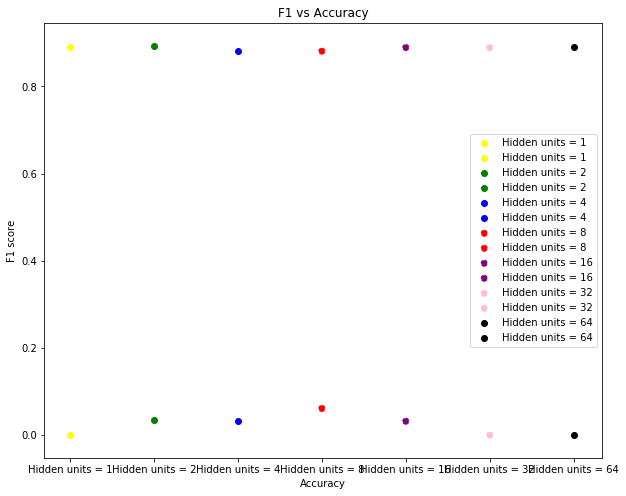

In [31]:
X = dfPokemonOneHotEncoded[['Type 1_Bug', 'Type 1_Dark', 'Type 1_Dragon', 'Type 1_Electric',
       'Type 1_Fairy', 'Type 1_Fighting', 'Type 1_Fire', 'Type 1_Flying',
       'Type 1_Ghost', 'Type 1_Grass', 'Type 1_Ground', 'Type 1_Ice',
       'Type 1_Normal', 'Type 1_Poison', 'Type 1_Psychic', 'Type 1_Rock',
       'Type 1_Steel', 'Type 1_Water', 'Type 2_Bug', 'Type 2_Dark',
       'Type 2_Dragon', 'Type 2_Electric', 'Type 2_Fairy', 'Type 2_Fighting',
       'Type 2_Fire', 'Type 2_Flying', 'Type 2_Ghost', 'Type 2_Grass',
       'Type 2_Ground', 'Type 2_Ice', 'Type 2_None', 'Type 2_Normal',
       'Type 2_Poison', 'Type 2_Psychic', 'Type 2_Rock', 'Type 2_Steel',
       'Type 2_Water', 'HP', 'Attack','Defense', 'Sp. Atk','Sp. Def','Speed','Generation','Has Gender_False', 'Has Gender_True']]
y = dfPokemonOneHotEncoded['Legendary_True']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=4211)


params = [{'hidden_layer_sizes': (1, )},
          {'hidden_layer_sizes': (2, )},
          {'hidden_layer_sizes': (4, )},
          {'hidden_layer_sizes': (8, )},
          {'hidden_layer_sizes': (16, )},
          {'hidden_layer_sizes': (32, )},
          {'hidden_layer_sizes': (64, )}
         ]

labels = ["Hidden units = 1", "Hidden units = 2",
          "Hidden units = 4",
          "Hidden units = 8", "Hidden units = 16",
          "Hidden units = 32", "Hidden units = 64"]

plot_args = [{'c': 'yellow', 'linestyle': '-'},
             {'c': 'green', 'linestyle': '-'},
             {'c': 'blue', 'linestyle': '-'},
             {'c': 'red', 'linestyle': '--'},
             {'c': 'purple', 'linestyle': '--'},
             {'c': 'pink', 'linestyle': '--'},
             {'c': 'black', 'linestyle': '-'}]

report= [[]]

meanAccuracy = []

meanF1 = []

def plot_on_dataset(X, y):
    plt.title('F1 vs Accuracy')
    mlps = []
    
    count = 0;
    for label, param in zip(labels, params):
        #Initialize list of train time, accuracy and f1 score to capture the performance of the models
        train_time = []
        accuracy = []
        f1 = []
        lastmlp = None
            
        for randomState in range(3):
            print("training: %s" % label)
            mlp = MLPClassifier(random_state=randomState,
                                    max_iter=500, early_stopping=True,learning_rate_init=.01,  **param)
            t0 = time.time()
            
            mlp.fit(X, y)
            
            t1 = time.time()
            thisTrainTime = t1 - t0
            train_time.append(thisTrainTime)
            

            mlps.append(mlp)
            lastmlp = mlp
            print("Training set score: %f" % mlp.score(X_train, y_train))
            print("Validation set score: %f" % mlp.validation_scores_[-1])
            print(mlp.get_params)
            
            y_pred = mlp.predict(X_valid)
            
            print("Training time: ", thisTrainTime)
            
            print('Accuracy:', accuracy_score(y_valid, y_pred))
            accuracy.append(accuracy_score(y_valid, y_pred))
            
            print('F1 Score:', f1_score(y_valid, y_pred),"\n")
            f1.append(f1_score(y_valid, y_pred))
            
            

            
        meanAccuracy.append(np.mean(accuracy))
        meanF1.append(np.mean(f1))
        
            
        plt.xlabel("Accuracy")
        plt.ylabel("F1 score")
        
        print("Summary for setting of single-hidden-layer model with Hidden layers = ", lastmlp.hidden_layer_sizes[0])
        print("Training time ;", "Mean : ", np.mean(train_time), "; Standard Deviation : ", np.std(train_time))
        print("Accuracy ;", "Mean : ", np.mean(accuracy), "; Standard Deviation : ", np.std(accuracy))
        print("F1 score ;", "Mean : ", np.mean(f1), "; Standard Deviation : ", np.std(f1),"\n")
        modelSummary = [train_time, accuracy, f1]
        report.append(modelSummary)
        display(meanAccuracy)
        display(meanF1)
        
        
    for Accuracy, F1, label, args in zip( meanAccuracy,meanF1 ,labels, plot_args):
        plt.scatter(label,Accuracy, label=label, **args)
        plt.scatter(label,F1, label=label, **args)


        
plt.figure(figsize=(10,8))
plot_on_dataset(X_train, y_train)
plt.legend()
plt.show()

# 3.4 Task 4: Predicting the Winners in the Pokemon Battles

In [32]:
dfBattlesWinnersPred = dfBattles.copy()
isFirstWinner = dfBattlesWinnersPred["Winner"] == dfBattlesWinnersPred["First_pokemon"] 
isFirstNotWinner = dfBattlesWinnersPred["Winner"] != dfBattlesWinnersPred["First_pokemon"] 
dfBattlesWinnersPred["Winner"][isFirstWinner] = 1
dfBattlesWinnersPred["Winner"][isFirstNotWinner] = 0

#Create a copy of dfPokemonOneHotEncoded, add suffix _First so as to merge and insert the information of First pokemon
dfPokemonFirstPokemon = dfPokemonOneHotEncoded.copy()
dfPokemonFirstPokemon.columns = [str(col) + '_First' for col in dfPokemonFirstPokemon.columns]
dfPokemonFirstPokemon.rename(columns={"#_First": "First_pokemon"},inplace=True)

#Create a copy of dfPokemonOneHotEncoded, add suffix _Second so as to merge and insert the information of Second pokemon
dfPokemonSecondPokemon = dfPokemonOneHotEncoded.copy()
dfPokemonSecondPokemon.columns = [str(col) + '_Second' for col in dfPokemonSecondPokemon.columns]
dfPokemonSecondPokemon.rename(columns={"#_Second": "Second_pokemon"},inplace=True)

#Merge the on the "First_pokemon" and "Second_pokemon" column to add the info for the first and second pokemons battling

dfBattlesWinnersPred = pd.merge(dfBattlesWinnersPred, dfPokemonFirstPokemon, on='First_pokemon', how='left')
dfBattlesWinnersPred = pd.merge(dfBattlesWinnersPred, dfPokemonSecondPokemon, on='Second_pokemon', how='left')

display(dfBattlesWinnersPred)
 

,First_pokemon,Second_pokemon,Winner,Name_First,Type 1_First,Type 2_First,HP_First,Attack_First,Defense_First,Sp. Atk_First,...,Type 2_Normal_Second,Type 2_Poison_Second,Type 2_Psychic_Second,Type 2_Rock_Second,Type 2_Steel_Second,Type 2_Water_Second,Has Gender_False_Second,Has Gender_True_Second,Legendary_False_Second,Legendary_True_Second
0,173,463,0,Totodile,Water,None,50,65,64,44,...,0,0,0,0,0,0,0,1,1,0
1,174,307,0,Croconaw,Water,None,65,80,80,59,...,0,0,0,0,0,0,0,1,1,0
2,772,181,1,Hawlucha,Fighting,Flying,78,92,75,74,...,0,0,0,0,0,0,0,1,1,0
3,430,356,1,DeoxysAttack Forme,Psychic,None,50,180,20,180,...,0,0,0,0,0,0,0,1,1,0
4,519,695,1,Magmortar,Fire,None,75,95,67,125,...,0,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,416,778,0,Regice,Ice,None,80,50,100,100,...,0,0,0,0,0,0,0,1,1,0
39996,221,265,0,Forretress,Bug,Steel,75,90,140,60,...,0,0,0,0,0,0,1,0,0,1
39997,35,448,0,Nidoran♀,Poison,None,55,47,52,40,...,0,0,0,0,0,0,0,1,1,0
39998,791,713,0,Noibat,Flying,Dragon,40,30,35,45,...,0,0,0,0,0,0,1,0,0,1


In [33]:
X = dfBattlesWinnersPred[['HP_First', 'Attack_First',
       'Defense_First', 'Sp. Atk_First', 'Sp. Def_First', 'Speed_First',
       'Generation_First','Win Rate_First', 'Type 1_Bug_First', 'Type 1_Dark_First',
       'Type 1_Dragon_First', 'Type 1_Electric_First',
       'Type 1_Fairy_First', 'Type 1_Fighting_First', 'Type 1_Fire_First',
       'Type 1_Flying_First', 'Type 1_Ghost_First', 'Type 1_Grass_First',
       'Type 1_Ground_First', 'Type 1_Ice_First', 'Type 1_Normal_First',
       'Type 1_Poison_First', 'Type 1_Psychic_First', 'Type 1_Rock_First',
       'Type 1_Steel_First', 'Type 1_Water_First', 'Type 2_Bug_First',
       'Type 2_Dark_First', 'Type 2_Dragon_First',
       'Type 2_Electric_First', 'Type 2_Fairy_First',
       'Type 2_Fighting_First', 'Type 2_Fire_First',
       'Type 2_Flying_First', 'Type 2_Ghost_First', 'Type 2_Grass_First',
       'Type 2_Ground_First', 'Type 2_Ice_First', 'Type 2_None_First',
       'Type 2_Normal_First', 'Type 2_Poison_First',
       'Type 2_Psychic_First', 'Type 2_Rock_First', 'Type 2_Steel_First',
       'Type 2_Water_First', 'Has Gender_False_First',
       'Has Gender_True_First', 'Legendary_False_First',
       'Legendary_True_First', 'HP_Second', 'Attack_Second', 'Defense_Second',
       'Sp. Atk_Second', 'Sp. Def_Second', 'Speed_Second',
       'Generation_Second','Win Rate_Second','Type 1_Bug_Second', 'Type 1_Dark_Second',
       'Type 1_Dragon_Second', 'Type 1_Electric_Second',
       'Type 1_Fairy_Second', 'Type 1_Fighting_Second',
       'Type 1_Fire_Second', 'Type 1_Flying_Second',
       'Type 1_Ghost_Second', 'Type 1_Grass_Second',
       'Type 1_Ground_Second', 'Type 1_Ice_Second',
       'Type 1_Normal_Second', 'Type 1_Poison_Second',
       'Type 1_Psychic_Second', 'Type 1_Rock_Second',
       'Type 1_Steel_Second', 'Type 1_Water_Second', 'Type 2_Bug_Second',
       'Type 2_Dark_Second', 'Type 2_Dragon_Second',
       'Type 2_Electric_Second', 'Type 2_Fairy_Second',
       'Type 2_Fighting_Second', 'Type 2_Fire_Second',
       'Type 2_Flying_Second', 'Type 2_Ghost_Second',
       'Type 2_Grass_Second', 'Type 2_Ground_Second', 'Type 2_Ice_Second',
       'Type 2_None_Second', 'Type 2_Normal_Second',
       'Type 2_Poison_Second', 'Type 2_Psychic_Second',
       'Type 2_Rock_Second', 'Type 2_Steel_Second', 'Type 2_Water_Second',
       'Has Gender_False_Second', 'Has Gender_True_Second',
       'Legendary_False_Second', 'Legendary_True_Second']]
y = dfBattlesWinnersPred['Winner']

In [34]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.001, random_state=4211, shuffle=True)

In [35]:
# Utility function to report best scores
def report(results, n_top):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})"
                  .format(results['mean_test_score'][candidate],
                          results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [36]:
random_dist = {'hidden_layer_sizes': [(64,),(32,),(16, ), (8, ), (4,)],
               'solver': ['sgd', 'adam'],
               'learning_rate': ['constant', 'invscaling', 'adaptive'],
               'learning_rate_init': loguniform(1e-3, 1e0),
               'activation': ['tanh', 'relu'],
              }

# run grid search
mlp = MLPClassifier(max_iter = 500, random_state=4211)
random_search = RandomizedSearchCV(
    mlp, random_dist,n_iter=10, cv=5, verbose=3)
start = time.time()
random_search.fit(X_train, y_train)

print("RandomSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time.time() - start, len(random_search.cv_results_['params'])))


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] activation=tanh, hidden_layer_sizes=(4,), learning_rate=invscaling, learning_rate_init=0.0013533217200327155, solver=sgd 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  activation=tanh, hidden_layer_sizes=(4,), learning_rate=invscaling, learning_rate_init=0.0013533217200327155, solver=sgd, score=0.936, total=   6.9s
[CV] activation=tanh, hidden_layer_sizes=(4,), learning_rate=invscaling, learning_rate_init=0.0013533217200327155, solver=sgd 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.8s remaining:    0.0s


[CV]  activation=tanh, hidden_layer_sizes=(4,), learning_rate=invscaling, learning_rate_init=0.0013533217200327155, solver=sgd, score=0.931, total=   6.4s
[CV] activation=tanh, hidden_layer_sizes=(4,), learning_rate=invscaling, learning_rate_init=0.0013533217200327155, solver=sgd 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.1s remaining:    0.0s


[CV]  activation=tanh, hidden_layer_sizes=(4,), learning_rate=invscaling, learning_rate_init=0.0013533217200327155, solver=sgd, score=0.928, total=   6.6s
[CV] activation=tanh, hidden_layer_sizes=(4,), learning_rate=invscaling, learning_rate_init=0.0013533217200327155, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(4,), learning_rate=invscaling, learning_rate_init=0.0013533217200327155, solver=sgd, score=0.934, total=   6.5s
[CV] activation=tanh, hidden_layer_sizes=(4,), learning_rate=invscaling, learning_rate_init=0.0013533217200327155, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(4,), learning_rate=invscaling, learning_rate_init=0.0013533217200327155, solver=sgd, score=0.935, total=   5.5s
[CV] activation=relu, hidden_layer_sizes=(32,), learning_rate=constant, learning_rate_init=0.016257681847785168, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(32,), learning_rate=constant, learning_rate_init=0.016257681847785168, solver=adam, score=0.919, total=  20.6s
[

[CV]  activation=tanh, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.04829984463929463, solver=sgd, score=0.936, total=  39.1s
[CV] activation=tanh, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.04829984463929463, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.04829984463929463, solver=sgd, score=0.939, total=  49.2s
[CV] activation=tanh, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.04829984463929463, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(64,), learning_rate=invscaling, learning_rate_init=0.04829984463929463, solver=sgd, score=0.941, total=  31.7s
[CV] activation=tanh, hidden_layer_sizes=(16,), learning_rate=adaptive, learning_rate_init=0.012510606736568529, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(16,), learning_rate=adaptive, learning_rate_init=0.012510606736568529, solver=adam, score=0.913, total=   3.0s
[CV] a

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 14.0min finished


RandomSearchCV took 927.95 seconds for 10 candidate parameter settings.


In [37]:
#Q11 Report the 10 combinations of the hyperparameter setting
report(random_search.cv_results_,10)

Model with rank: 1
Mean validation score: 0.948 (std: 0.006)
Parameters: {'activation': 'relu', 'hidden_layer_sizes': (64,), 'learning_rate': 'adaptive', 'learning_rate_init': 0.0022394749337885087, 'solver': 'adam'}

Model with rank: 2
Mean validation score: 0.942 (std: 0.003)
Parameters: {'activation': 'relu', 'hidden_layer_sizes': (16,), 'learning_rate': 'adaptive', 'learning_rate_init': 0.010301139335684748, 'solver': 'adam'}

Model with rank: 3
Mean validation score: 0.939 (std: 0.003)
Parameters: {'activation': 'tanh', 'hidden_layer_sizes': (64,), 'learning_rate': 'invscaling', 'learning_rate_init': 0.04829984463929463, 'solver': 'sgd'}

Model with rank: 4
Mean validation score: 0.936 (std: 0.010)
Parameters: {'activation': 'relu', 'hidden_layer_sizes': (32,), 'learning_rate': 'constant', 'learning_rate_init': 0.016257681847785168, 'solver': 'adam'}

Model with rank: 5
Mean validation score: 0.935 (std: 0.004)
Parameters: {'activation': 'tanh', 'hidden_layer_sizes': (4,), 'learni

In [38]:
#Q12 Report the top 3 best hyperparameter setting
report(random_search.cv_results_,3)

Model with rank: 1
Mean validation score: 0.948 (std: 0.006)
Parameters: {'activation': 'relu', 'hidden_layer_sizes': (64,), 'learning_rate': 'adaptive', 'learning_rate_init': 0.0022394749337885087, 'solver': 'adam'}

Model with rank: 2
Mean validation score: 0.942 (std: 0.003)
Parameters: {'activation': 'relu', 'hidden_layer_sizes': (16,), 'learning_rate': 'adaptive', 'learning_rate_init': 0.010301139335684748, 'solver': 'adam'}

Model with rank: 3
Mean validation score: 0.939 (std: 0.003)
Parameters: {'activation': 'tanh', 'hidden_layer_sizes': (64,), 'learning_rate': 'invscaling', 'learning_rate_init': 0.04829984463929463, 'solver': 'sgd'}



In [39]:
#Preprocessing for test set

#Convert the winner column to 1 and 0 (1 if First_pokemon won, and 0 otherwise)
dfTest = pd.read_csv("./q4_test.csv")
isFirstWinner = dfTest["Winner"] == dfTest["First_pokemon"] 
isFirstNotWinner = dfTest["Winner"] != dfTest["First_pokemon"] 
dfTest["Winner"][isFirstWinner] = 1
dfTest["Winner"][isFirstNotWinner] = 0


dfTest = pd.merge(dfTest, dfPokemonFirstPokemon, on='First_pokemon', how='left')
dfTest = pd.merge(dfTest, dfPokemonSecondPokemon, on='Second_pokemon', how='left')
print("dfTest ")
display(dfTest)
dfTest.columns.values

dfTest 


,First_pokemon,Second_pokemon,Winner,Name_First,Type 1_First,Type 2_First,HP_First,Attack_First,Defense_First,Sp. Atk_First,...,Type 2_Normal_Second,Type 2_Poison_Second,Type 2_Psychic_Second,Type 2_Rock_Second,Type 2_Steel_Second,Type 2_Water_Second,Has Gender_False_Second,Has Gender_True_Second,Legendary_False_Second,Legendary_True_Second
0,333,57,0,Aggron,Steel,Rock,70,110,180,60,...,0,0,0,0,0,0,0,1,1,0
1,541,105,1,Dialga,Steel,Dragon,100,120,120,150,...,0,0,0,0,0,0,0,1,1,0
2,665,687,0,Eelektrik,Electric,None,65,85,70,75,...,0,0,0,0,1,0,0,1,1,0
3,145,205,0,Eevee,Normal,None,55,55,50,45,...,0,0,0,0,0,0,0,1,1,0
4,598,698,1,Seismitoad,Water,Ground,105,95,75,85,...,0,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,413,279,0,Metagross,Steel,Psychic,80,135,130,95,...,0,0,0,0,0,0,0,1,1,0
9996,571,581,0,Pansage,Grass,None,50,53,48,53,...,0,0,0,0,0,0,0,1,1,0
9997,713,279,1,Kyurem White Kyurem,Dragon,Ice,125,120,90,170,...,0,0,0,0,0,0,0,1,1,0
9998,248,638,1,Houndoom,Dark,Fire,75,90,50,110,...,0,0,0,0,0,0,0,1,1,0


array(['First_pokemon', 'Second_pokemon', 'Winner', 'Name_First',
       'Type 1_First', 'Type 2_First', 'HP_First', 'Attack_First',
       'Defense_First', 'Sp. Atk_First', 'Sp. Def_First', 'Speed_First',
       'Generation_First', 'Has Gender_First', 'Legendary_First',
       'Win Rate_First', 'Type 1_Bug_First', 'Type 1_Dark_First',
       'Type 1_Dragon_First', 'Type 1_Electric_First',
       'Type 1_Fairy_First', 'Type 1_Fighting_First', 'Type 1_Fire_First',
       'Type 1_Flying_First', 'Type 1_Ghost_First', 'Type 1_Grass_First',
       'Type 1_Ground_First', 'Type 1_Ice_First', 'Type 1_Normal_First',
       'Type 1_Poison_First', 'Type 1_Psychic_First', 'Type 1_Rock_First',
       'Type 1_Steel_First', 'Type 1_Water_First', 'Type 2_Bug_First',
       'Type 2_Dark_First', 'Type 2_Dragon_First',
       'Type 2_Electric_First', 'Type 2_Fairy_First',
       'Type 2_Fighting_First', 'Type 2_Fire_First',
       'Type 2_Flying_First', 'Type 2_Ghost_First', 'Type 2_Grass_First',
       

In [40]:
X_test = dfTest[['HP_First', 'Attack_First',
       'Defense_First', 'Sp. Atk_First', 'Sp. Def_First', 'Speed_First',
       'Generation_First','Win Rate_First', 'Type 1_Bug_First', 'Type 1_Dark_First',
       'Type 1_Dragon_First', 'Type 1_Electric_First',
       'Type 1_Fairy_First', 'Type 1_Fighting_First', 'Type 1_Fire_First',
       'Type 1_Flying_First', 'Type 1_Ghost_First', 'Type 1_Grass_First',
       'Type 1_Ground_First', 'Type 1_Ice_First', 'Type 1_Normal_First',
       'Type 1_Poison_First', 'Type 1_Psychic_First', 'Type 1_Rock_First',
       'Type 1_Steel_First', 'Type 1_Water_First', 'Type 2_Bug_First',
       'Type 2_Dark_First', 'Type 2_Dragon_First',
       'Type 2_Electric_First', 'Type 2_Fairy_First',
       'Type 2_Fighting_First', 'Type 2_Fire_First',
       'Type 2_Flying_First', 'Type 2_Ghost_First', 'Type 2_Grass_First',
       'Type 2_Ground_First', 'Type 2_Ice_First', 'Type 2_None_First',
       'Type 2_Normal_First', 'Type 2_Poison_First',
       'Type 2_Psychic_First', 'Type 2_Rock_First', 'Type 2_Steel_First',
       'Type 2_Water_First', 'Has Gender_False_First',
       'Has Gender_True_First', 'Legendary_False_First',
       'Legendary_True_First', 'HP_Second', 'Attack_Second', 'Defense_Second',
       'Sp. Atk_Second', 'Sp. Def_Second', 'Speed_Second',
       'Generation_Second','Win Rate_Second','Type 1_Bug_Second', 'Type 1_Dark_Second',
       'Type 1_Dragon_Second', 'Type 1_Electric_Second',
       'Type 1_Fairy_Second', 'Type 1_Fighting_Second',
       'Type 1_Fire_Second', 'Type 1_Flying_Second',
       'Type 1_Ghost_Second', 'Type 1_Grass_Second',
       'Type 1_Ground_Second', 'Type 1_Ice_Second',
       'Type 1_Normal_Second', 'Type 1_Poison_Second',
       'Type 1_Psychic_Second', 'Type 1_Rock_Second',
       'Type 1_Steel_Second', 'Type 1_Water_Second', 'Type 2_Bug_Second',
       'Type 2_Dark_Second', 'Type 2_Dragon_Second',
       'Type 2_Electric_Second', 'Type 2_Fairy_Second',
       'Type 2_Fighting_Second', 'Type 2_Fire_Second',
       'Type 2_Flying_Second', 'Type 2_Ghost_Second',
       'Type 2_Grass_Second', 'Type 2_Ground_Second', 'Type 2_Ice_Second',
       'Type 2_None_Second', 'Type 2_Normal_Second',
       'Type 2_Poison_Second', 'Type 2_Psychic_Second',
       'Type 2_Rock_Second', 'Type 2_Steel_Second', 'Type 2_Water_Second',
       'Has Gender_False_Second', 'Has Gender_True_Second',
       'Legendary_False_Second', 'Legendary_True_Second']]
y_test = dfTest['Winner']

Accuracy for classifier:
0.9547
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(64,), learning_rate='adaptive',
              learning_rate_init=0.0022394749337885087, max_fun=15000,
              max_iter=500, momentum=0.9, n_iter_no_change=10,
              nesterovs_momentum=True, power_t=0.5, random_state=4211,
              shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
              verbose=False, warm_start=False)
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      5282
           1       0.96      0.95      0.95      4718

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000

Confusion matrix:
[[5086  196]
 [ 257 4461]]


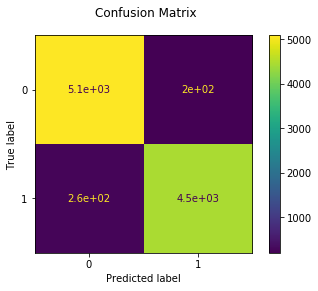

In [41]:

predicted = random_search.predict(X_test)
print("Accuracy for classifier:\n" + str(accuracy_score(y_test, predicted)))

print(random_search.best_estimator_)
print(classification_report(y_test, predicted))

disp = plot_confusion_matrix(random_search, X_test, y_test)
disp.figure_.suptitle("Confusion Matrix")
print("Confusion matrix:\n%s" % disp.confusion_matrix)